# Evaluating Semantic Search Systems

## 1. <font color='red'> Install and Import Required Libraries </font>

---

In [1]:
# Install the wikipediaapi library
!pip install wikipedia-api

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.7.3-py3-none-any.whl size=14325 sha256=f62b792b91e5333d3209d1224c4824489a60b71ee3c220aa8682fb20e6f41951
  Stored in directory: /root/.cache/pip/wheels/39/c8/cd/ba9a385ad2f6e457226fe2a7dceaeb0c17a19346d2e78ff4be
Successfully built wikipedia-api


In [2]:
# Import required libraries

import numpy as np
import pandas as pd
import wikipediaapi

## 2. <font color = 'red'> Document Chunking </font>

We will generate embeddings for texts related to various Wikipedia articles. But since you are using large blocks of text, before generating the embeddings, you need to generate the chunks. Let's start with a basic chunking technique, and chunk the text by paragraph.

In [3]:
# Call the Wikipedia function through a user_agent and specify the language

string = "SemSearchDemo/1.0 (Akshay G;)"
wiki_wiki = wikipediaapi.Wikipedia(user_agent= string, language= 'en')

In [4]:
# Extract the wikipedia page for the page - " The Shawshank Redemption"

page = wiki_wiki.page("The Shawshank Redemption")

In [52]:
# Check the entire page's text

page.text

'The Shawshank Redemption is a 1994 American prison drama film written and directed by Frank Darabont, based on the 1982 Stephen King novella Rita Hayworth and Shawshank Redemption. The film tells the story of banker Andy Dufresne (Tim Robbins), who is sentenced to life in Shawshank State Penitentiary for the murders of his wife and her lover, despite his claims of innocence. Over the following two decades, he befriends a fellow prisoner, contraband smuggler Ellis "Red" Redding (Morgan Freeman), and becomes instrumental in a money laundering operation led by the prison warden Samuel Norton (Bob Gunton). William Sadler, Clancy Brown, Gil Bellows, and James Whitmore appear in supporting roles.\nDarabont purchased the film rights to King\'s story in 1987, but development did not begin until five years later, when he wrote the script over eight weeks. Two weeks after submitting his script to Castle Rock Entertainment, Darabont secured a $25 million budget to produce The Shawshank Redemptio

In [7]:
page.sections

[Section: Plot (1):
 In 1947, Portland, Maine, banker Andy Dufresne arrives at Shawshank State Prison to serve two consecutive life sentences for murdering his wife and her lover. He is befriended by Ellis Boyd "Red" Redding, a contraband smuggler serving a life sentence, who procures for him a rock hammer and a large poster of Rita Hayworth. Assigned to work in the prison laundry, Andy is frequently raped by "the Sisters" gang, led by Bogs Diamond.
 In 1949, Andy overhears the captain of the guards, Byron Hadley, complaining about being taxed on an inheritance and offers to help him shelter the money legally. After the Sisters beat Andy to near-death, Hadley cripples Bogs, who is subsequently transferred to a minimum security hospital; Andy is not attacked again. Warden Samuel Norton assigns Andy to the prison's decrepit library, ostensibly to assist elderly inmate Brooks Hatlen, but in reality, to leverage Andy's financial expertise for managing the finances of the warden and other p

### 2.1 <font color = 'red'> Fixed-Size Chunking </font>

In fixed-size chunking, the document is split into fixed-size windows with each window representing a separate document chunk.

In [8]:
# Function to extract and store Wikipedia page information

def process_page(page_title):

    page = wiki_wiki.page(page_title)

    if page.exists():
        page_text = page.text
        chunk_size = 1000  # Set your desired chunk size (in characters)

        text_chunks = split_text_into_chunks(page_text, chunk_size)

        # Create a DataFrame to store the chunks and page title
        data = {'Title': [], 'Chunk Text': []}

        for idx, chunk in enumerate(text_chunks):
            data['Title'].append(page_title)
            data['Chunk Text'].append(chunk)

        return pd.DataFrame(data)

    else:
        print(f"The page '{page_title}' does not exist on Wikipedia.")
        return None

In [9]:
# Function to split text into fixed-size chunks

def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

#### Chunking for multiple documents

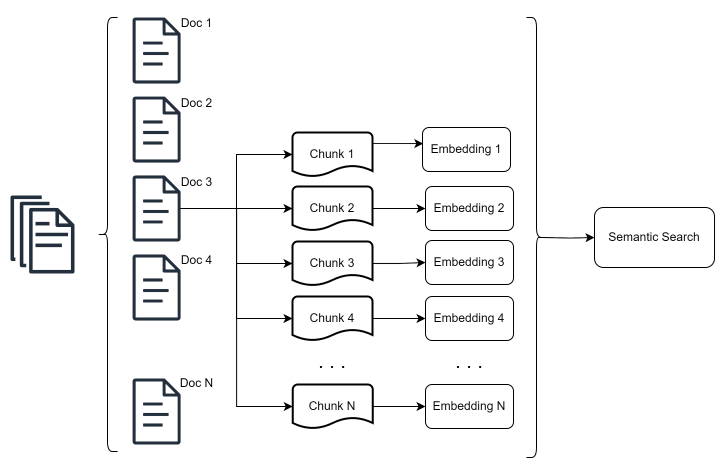

In [53]:
# Iterating over all page titles to create the final df with individual chunks

page_titles = ["The Shawshank Redemption", "The Dark Knight", "Pulp Fiction", "The Godfather", "Goodfellas"]

all_dfs = []

for title in page_titles:
    df = process_page(title)
    if df is not None:
        all_dfs.append(df)


fixed_chunk_df = pd.concat(all_dfs, ignore_index=True)
fixed_chunk_df

Title  \
0    The Shawshank Redemption   
1    The Shawshank Redemption   
2    The Shawshank Redemption   
3    The Shawshank Redemption   
4    The Shawshank Redemption   
..                        ...   
278                Goodfellas   
279                Goodfellas   
280                Goodfellas   
281                Goodfellas   
282                Goodfellas   

                                            Chunk Text  
0    The Shawshank Redemption is a 1994 American pr...  
1    which started pre-production in January 1993. ...  
2    theatrical re-release that, combined with inte...  
3    1947, Portland, Maine, banker Andy Dufresne ar...  
4    starts writing weekly letters to the state leg...  
..                                                 ...  
278  Films of the Last 25 Years. Time included Good...  
279  there's something operatic about it, classical...  
280  Winkler and his son, David. Luc Besson's 2013 ...  
281  Years... 100 Movies - #94 AFI's 100 Years... 1...  
282  Press. ISBN 978-1-56025-470-6. Pileggi, Nichol...  

[283 rows x 2 columns]

### <font color = 'red'>  2.2 Chunking by Paragraph </font>

Here, we will try to chunk and extract individual paragraphs using the newline character.

In [11]:
# Defining some redundant sections

redundant_sections = [
    "See also",
    "References",
    "External links",
    "Further reading",
    "Footnotes",
    "Bibliography",
    "Sources",
    "Citations",
    "Literature",
    "Footnotes",
    "Notes and references",
    "Photo gallery",
    "Works cited",
    "Photos",
    "Gallery",
    "Notes",
    "References and sources",
    "References and notes",
]

In [54]:
# Function to extract and store Wikipedia page information

def extract_wikipedia_page(page_title):
    page = wiki_wiki.page(page_title)
    if page.exists():
        title = page.title
        paragraphs = []

        # Extract introduction if available
        if page.summary:
            paragraphs.extend(page.summary.split('\n'))

        # Extract paragraphs from sections
        for section in page.sections:
          if section.title not in redundant_sections:
            extract_paragraphs(section, paragraphs)

        return title, paragraphs

    else:
        return None, None

In [55]:
# Function to recursively extract paragraphs from sections
def extract_paragraphs(section, accumulated_text):
    accumulated_text.extend(section.text.split('\n'))
    for sub_section in section.sections:
        extract_paragraphs(sub_section, accumulated_text)

In [56]:
# List of Wikipedia page titles
page_titles = ["The Shawshank Redemption", "The Dark Knight", "Pulp Fiction", "The Godfather", "Goodfellas"]

# Initialize lists to store data
titles = []
paragraphs = []

# Extract data and store in lists
for title in page_titles:
    extracted_title, extracted_paragraphs = extract_wikipedia_page(title)
    if extracted_title and extracted_paragraphs:
        titles.extend([extracted_title] * len(extracted_paragraphs))
        paragraphs.extend(extracted_paragraphs)

# Create a DataFrame
data = {'Title': titles, 'Chunk Text': paragraphs}
para_chunk_df = pd.DataFrame(data)

# Display the DataFrame
para_chunk_df = para_chunk_df[para_chunk_df['Chunk Text'] != '']  # Remove empty paragraphs
para_chunk_df = para_chunk_df.reset_index(drop=True)   # Reset index
para_chunk_df

Title  \
0    The Shawshank Redemption   
1    The Shawshank Redemption   
2    The Shawshank Redemption   
3    The Shawshank Redemption   
4    The Shawshank Redemption   
..                        ...   
436                Goodfellas   
437                Goodfellas   
438                Goodfellas   
439                Goodfellas   
440                Goodfellas   

                                            Chunk Text  
0    The Shawshank Redemption is a 1994 American pr...  
1    Darabont purchased the film rights to King's s...  
2    While The Shawshank Redemption received critic...  
3    Over 320,000 VHS rental copies were shipped th...  
4    In 1947, Portland, Maine, banker Andy Dufresne...  
..                                                 ...  
436                AFI's 100 Years... 100 Movies - #94  
437  AFI's 100 Years... 100 Movies (10th Anniversar...  
438                 AFI's 10 Top 10 - #2 Gangster film  
439  AFI's 100 Years... 100 Heroes and Villains - T...  
440  AFI's 100 Years... 100 Movie Quotes - "Funny h...  

[441 rows x 2 columns]

### <font color = 'red'>  2.3 Chunking by Sections </font>

Wikipedia already has the page divided into neat sections and subsections. Let's leverage that for chunking.

In [57]:
# Function to extract and store Wikipedia page sections
def extract_wikipedia_sections(page_title):
    page = wiki_wiki.page(page_title)
    if page.exists():
        title = page.title
        sections = []

        # Extract introduction if available
        introduction = page.summary
        if introduction:
            sections.append(("Introduction", introduction))

        # Extract all sections and subsections recursively
        def recursive_extraction(section):
            section_text = section.text
            if section_text:
                sections.append((section.title, section_text))
            for sub_section in section.sections:
                recursive_extraction(sub_section)

        for section in page.sections:
            if section.title not in redundant_sections:
                recursive_extraction(section)

        return title, sections

    else:
        return None, None

In [58]:
# List of Wikipedia page titles
page_titles = ["The Shawshank Redemption", "The Dark Knight", "Pulp Fiction", "The Godfather", "Goodfellas"]

# Initialize lists to store data
titles = []
section_titles = []
section_texts = []

# Extract data and store in lists
for title in page_titles:
    extracted_title, extracted_sections = extract_wikipedia_sections(title)
    if extracted_title and extracted_sections:
        for section_title, section_text in extracted_sections:
            titles.append(extracted_title)
            section_titles.append(section_title)
            section_texts.append(section_text)

# Create a DataFrame
data = {'Title': titles, 'Section Title': section_titles, 'Chunk Text': section_texts}
section_chunk_df = pd.DataFrame(data)

# Display the DataFrame
section_chunk_df = section_chunk_df[section_chunk_df['Chunk Text'] != '']  # Remove empty sections
section_chunk_df = section_chunk_df.reset_index(drop=True)  # Reset index
section_chunk_df

Title      Section Title  \
0   The Shawshank Redemption       Introduction   
1   The Shawshank Redemption               Plot   
2   The Shawshank Redemption               Cast   
3   The Shawshank Redemption           Analysis   
4   The Shawshank Redemption        Development   
..                       ...                ...   
94                Goodfellas         Box office   
95                Goodfellas  Critical response   
96                Goodfellas              Lists   
97                Goodfellas          Accolades   
98                Goodfellas             Legacy   

                                           Chunk Text  
0   The Shawshank Redemption is a 1994 American pr...  
1   In 1947, Portland, Maine, banker Andy Dufresne...  
2   Tim Robbins as Andy Dufresne: A banker sentenc...  
3   The film has been interpreted as being grounde...  
4   Frank Darabont first collaborated with author ...  
..                                                ...  
94  Goodfellas grossed $6.3 million from 1,070 the...  
95  According to review aggregator Rotten Tomatoes...  
96  The film was ranked the best of 1990 by Roger ...  
97  Goodfellas is 1 of 8 films to have won Best Pi...  
98  Goodfellas is No. 94 on the American Film Inst...  

[99 rows x 3 columns]

In [18]:
fixed_chunk_df

Title  \
0    The Shawshank Redemption   
1    The Shawshank Redemption   
2    The Shawshank Redemption   
3    The Shawshank Redemption   
4    The Shawshank Redemption   
..                        ...   
278                Goodfellas   
279                Goodfellas   
280                Goodfellas   
281                Goodfellas   
282                Goodfellas   

                                            Chunk Text  
0    The Shawshank Redemption is a 1994 American pr...  
1    which started pre-production in January 1993. ...  
2    theatrical re-release that, combined with inte...  
3    1947, Portland, Maine, banker Andy Dufresne ar...  
4    starts writing weekly letters to the state leg...  
..                                                 ...  
278  Films of the Last 25 Years. Time included Good...  
279  there's something operatic about it, classical...  
280  Winkler and his son, David. Luc Besson's 2013 ...  
281  Years... 100 Movies - #94 AFI's 100 Years... 1...  
282  Press. ISBN 978-1-56025-470-6. Pileggi, Nichol...  

[283 rows x 2 columns]

In [19]:
para_chunk_df

Title  \
0    The Shawshank Redemption   
1    The Shawshank Redemption   
2    The Shawshank Redemption   
3    The Shawshank Redemption   
4    The Shawshank Redemption   
..                        ...   
436                Goodfellas   
437                Goodfellas   
438                Goodfellas   
439                Goodfellas   
440                Goodfellas   

                                            Chunk Text  
0    The Shawshank Redemption is a 1994 American pr...  
1    Darabont purchased the film rights to King's s...  
2    While The Shawshank Redemption received critic...  
3    Over 320,000 VHS rental copies were shipped th...  
4    In 1947, Portland, Maine, banker Andy Dufresne...  
..                                                 ...  
436                AFI's 100 Years... 100 Movies - #94  
437  AFI's 100 Years... 100 Movies (10th Anniversar...  
438                 AFI's 10 Top 10 - #2 Gangster film  
439  AFI's 100 Years... 100 Heroes and Villains - T...  
440  AFI's 100 Years... 100 Movie Quotes - "Funny h...  

[441 rows x 2 columns]

In [20]:
section_chunk_df

Title      Section Title  \
0   The Shawshank Redemption       Introduction   
1   The Shawshank Redemption               Plot   
2   The Shawshank Redemption               Cast   
3   The Shawshank Redemption           Analysis   
4   The Shawshank Redemption        Development   
..                       ...                ...   
94                Goodfellas         Box office   
95                Goodfellas  Critical response   
96                Goodfellas              Lists   
97                Goodfellas          Accolades   
98                Goodfellas             Legacy   

                                           Chunk Text  
0   The Shawshank Redemption is a 1994 American pr...  
1   In 1947, Portland, Maine, banker Andy Dufresne...  
2   Tim Robbins as Andy Dufresne: A banker sentenc...  
3   The film has been interpreted as being grounde...  
4   Frank Darabont first collaborated with author ...  
..                                                ...  
94  Goodfellas grossed $6.3 million from 1,070 the...  
95  According to review aggregator Rotten Tomatoes...  
96  The film was ranked the best of 1990 by Roger ...  
97  Goodfellas is 1 of 8 films to have won Best Pi...  
98  Goodfellas is No. 94 on the American Film Inst...  

[99 rows x 3 columns]

## 3. <font color = 'red'> Generating Embeddings </font>

#### Encoding Pipeline

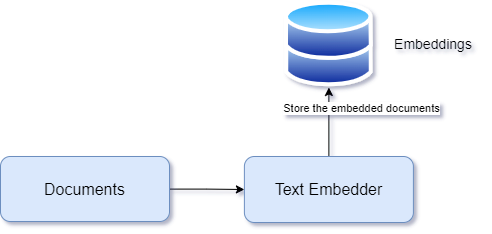

In [21]:
# Install the sentence transformers library

!pip install sentence-transformers

In [22]:
from sentence_transformers import SentenceTransformer, util

In [23]:
# Load pre-trained Sentence Transformer model

model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [24]:
# Function to generate embeddings for text
def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=True)
    return embeddings

In [25]:
def generate_embeddings_on_df(df):
  df['Embeddings'] = df['Chunk Text'].apply(lambda x: generate_embeddings([x])[0])

In [65]:
# Create embeddings for 'Chunk Text' column on all three dataframes

generate_embeddings_on_df(fixed_chunk_df)

In [66]:
generate_embeddings_on_df(para_chunk_df)

In [67]:
generate_embeddings_on_df(section_chunk_df)

In [29]:
fixed_chunk_df

Title  \
0    The Shawshank Redemption   
1    The Shawshank Redemption   
2    The Shawshank Redemption   
3    The Shawshank Redemption   
4    The Shawshank Redemption   
..                        ...   
278                Goodfellas   
279                Goodfellas   
280                Goodfellas   
281                Goodfellas   
282                Goodfellas   

                                            Chunk Text  \
0    The Shawshank Redemption is a 1994 American pr...   
1    which started pre-production in January 1993. ...   
2    theatrical re-release that, combined with inte...   
3    1947, Portland, Maine, banker Andy Dufresne ar...   
4    starts writing weekly letters to the state leg...   
..                                                 ...   
278  Films of the Last 25 Years. Time included Good...   
279  there's something operatic about it, classical...   
280  Winkler and his son, David. Luc Besson's 2013 ...   
281  Years... 100 Movies - #94 AFI's 100 Years... 1...   
282  Press. ISBN 978-1-56025-470-6. Pileggi, Nichol...   

                                            Embeddings  
0    [tensor(-0.0450), tensor(-0.0140), tensor(-0.0...  
1    [tensor(-0.0257), tensor(-0.0314), tensor(-0.0...  
2    [tensor(0.0311), tensor(-0.0278), tensor(-0.02...  
3    [tensor(0.0041), tensor(0.0098), tensor(-0.082...  
4    [tensor(-0.0452), tensor(-0.0158), tensor(-0.0...  
..                                                 ...  
278  [tensor(-0.0466), tensor(-0.0628), tensor(-0.0...  
279  [tensor(-0.0401), tensor(-0.0292), tensor(-0.0...  
280  [tensor(-0.0449), tensor(0.0130), tensor(-0.10...  
281  [tensor(-0.1441), tensor(-0.0397), tensor(-0.0...  
282  [tensor(-0.1011), tensor(-0.0392), tensor(-0.0...  

[283 rows x 3 columns]

In [30]:
para_chunk_df

Title  \
0    The Shawshank Redemption   
1    The Shawshank Redemption   
2    The Shawshank Redemption   
3    The Shawshank Redemption   
4    The Shawshank Redemption   
..                        ...   
436                Goodfellas   
437                Goodfellas   
438                Goodfellas   
439                Goodfellas   
440                Goodfellas   

                                            Chunk Text  \
0    The Shawshank Redemption is a 1994 American pr...   
1    Darabont purchased the film rights to King's s...   
2    While The Shawshank Redemption received critic...   
3    Over 320,000 VHS rental copies were shipped th...   
4    In 1947, Portland, Maine, banker Andy Dufresne...   
..                                                 ...   
436                AFI's 100 Years... 100 Movies - #94   
437  AFI's 100 Years... 100 Movies (10th Anniversar...   
438                 AFI's 10 Top 10 - #2 Gangster film   
439  AFI's 100 Years... 100 Heroes and Villains - T...   
440  AFI's 100 Years... 100 Movie Quotes - "Funny h...   

                                            Embeddings  
0    [tensor(-0.0596), tensor(-0.0301), tensor(-0.0...  
1    [tensor(-0.0351), tensor(-0.0152), tensor(-0.0...  
2    [tensor(-0.0052), tensor(-0.0282), tensor(-0.0...  
3    [tensor(0.0229), tensor(-0.0337), tensor(-0.02...  
4    [tensor(-0.0203), tensor(-0.0079), tensor(-0.0...  
..                                                 ...  
436  [tensor(-0.0367), tensor(-0.0243), tensor(-0.0...  
437  [tensor(-0.0572), tensor(-0.0156), tensor(0.00...  
438  [tensor(-0.0587), tensor(-0.0536), tensor(-0.0...  
439  [tensor(-0.0658), tensor(0.0377), tensor(-0.08...  
440  [tensor(-0.0707), tensor(0.0063), tensor(0.015...  

[441 rows x 3 columns]

In [31]:
section_chunk_df

Title      Section Title  \
0   The Shawshank Redemption       Introduction   
1   The Shawshank Redemption               Plot   
2   The Shawshank Redemption               Cast   
3   The Shawshank Redemption           Analysis   
4   The Shawshank Redemption        Development   
..                       ...                ...   
94                Goodfellas         Box office   
95                Goodfellas  Critical response   
96                Goodfellas              Lists   
97                Goodfellas          Accolades   
98                Goodfellas             Legacy   

                                           Chunk Text  \
0   The Shawshank Redemption is a 1994 American pr...   
1   In 1947, Portland, Maine, banker Andy Dufresne...   
2   Tim Robbins as Andy Dufresne: A banker sentenc...   
3   The film has been interpreted as being grounde...   
4   Frank Darabont first collaborated with author ...   
..                                                ...   
94  Goodfellas grossed $6.3 million from 1,070 the...   
95  According to review aggregator Rotten Tomatoes...   
96  The film was ranked the best of 1990 by Roger ...   
97  Goodfellas is 1 of 8 films to have won Best Pi...   
98  Goodfellas is No. 94 on the American Film Inst...   

                                           Embeddings  
0   [tensor(-0.0461), tensor(-0.0266), tensor(-0.0...  
1   [tensor(0.0095), tensor(-0.0004), tensor(-0.05...  
2   [tensor(-0.0502), tensor(-0.0536), tensor(-0.1...  
3   [tensor(-0.0556), tensor(0.0511), tensor(-0.08...  
4   [tensor(-0.0313), tensor(-0.0320), tensor(-0.0...  
..                                                ...  
94  [tensor(0.0283), tensor(-0.0623), tensor(-0.01...  
95  [tensor(-0.0106), tensor(-0.0307), tensor(-0.1...  
96  [tensor(-0.0058), tensor(-0.1028), tensor(-0.0...  
97  [tensor(0.0252), tensor(-0.0542), tensor(-0.02...  
98  [tensor(-0.0018), tensor(-0.0567), tensor(-0.0...  

[99 rows x 4 columns]

In [32]:
fixed_chunk_df['Embeddings'][0]

tensor([-4.5033e-02, -1.3977e-02, -9.2651e-02,  1.9057e-02, -5.0282e-02,
         5.1733e-02,  7.6636e-02,  6.2789e-03,  1.3326e-01, -2.8877e-02,
        -7.8991e-02,  3.4776e-02,  6.7544e-02,  2.7707e-02, -3.2757e-02,
         7.0297e-03, -6.2187e-03,  3.7992e-02,  4.2887e-03, -1.2072e-02,
         4.4106e-02, -3.9875e-03,  3.0265e-02, -2.5034e-02, -5.4251e-02,
        -4.7046e-02,  2.2602e-02, -7.2564e-02, -9.4632e-02,  5.5642e-02,
        -1.2507e-02, -6.7893e-02, -2.8608e-03, -2.0439e-02,  2.9972e-04,
         9.3546e-02,  3.9044e-02, -6.1843e-03, -1.3579e-03, -7.1189e-03,
        -3.8805e-03,  2.7993e-02,  4.0154e-02,  4.7883e-02,  7.8012e-02,
        -6.4884e-02, -1.4063e-02, -7.8476e-02,  7.3105e-03, -9.6542e-02,
        -2.5342e-02,  1.1205e-01,  4.0520e-04,  1.4688e-02,  1.6884e-03,
        -5.7545e-02, -4.6751e-03, -1.0145e-03,  1.2586e-02, -7.7156e-02,
        -3.4486e-02,  6.0280e-03,  2.0064e-02, -1.4259e-02,  7.7491e-02,
         1.0733e-02,  1.7110e-02, -8.4493e-03,  2.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the embeddings in a CSV

output_path = '/content/drive/My Drive/HelpMate AI Codes/'


# Save the dataframe with embeddings
fixed_chunk_df.to_csv(output_path+"fixed_chunk_embeddings.csv", index=False)
para_chunk_df.to_csv(output_path+"para_chunk_embeddings.csv", index=False)
section_chunk_df.to_csv(output_path+"section_chunk_embeddings.csv", index=False)

# 4. <font color = 'red'> Building the Semantic Search </font>

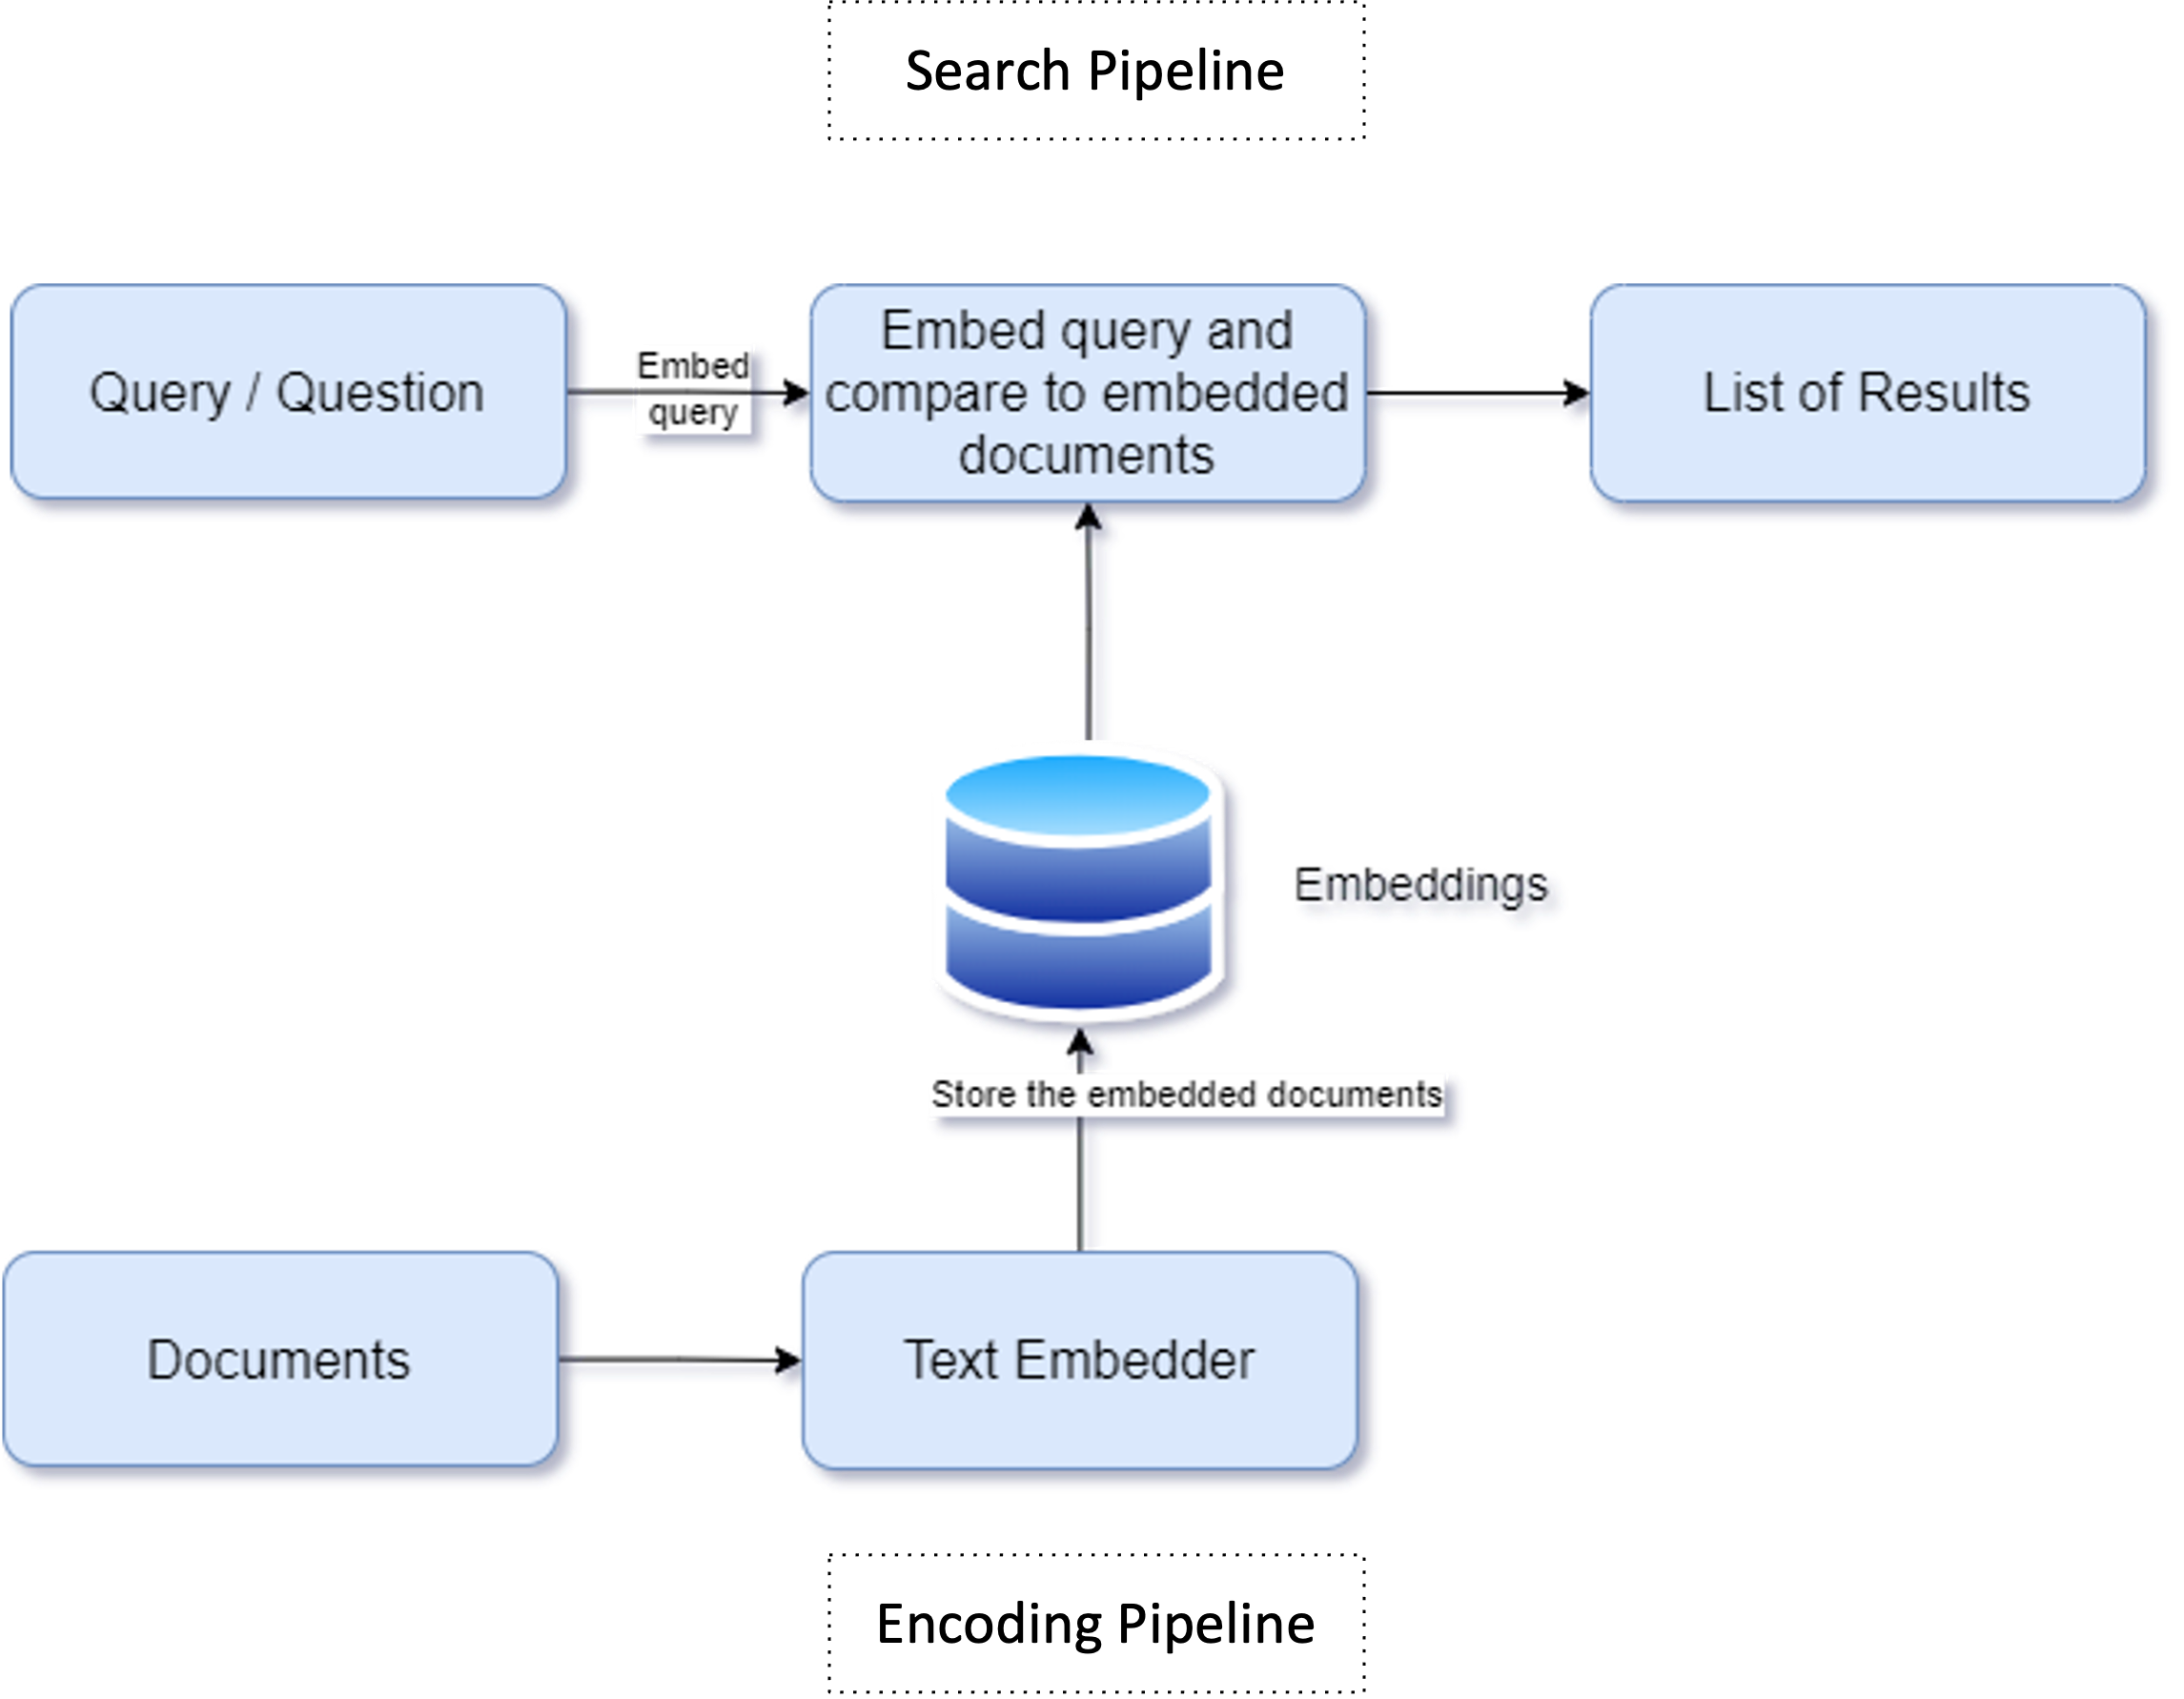

In [59]:
# Read user input query
user_query = input()

Who are the actors in the movie The Shawshank Redemption?


In [69]:
# Define the function for calculating cosine similarity

def calculate_similarity(embedding1, embedding2):
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2)
    # Convert the result to a Python float
    similarity = cosine_score.item()

    return similarity

In [68]:
# Function to perform semantic search and return ranked chunks
def semantic_search(user_query, df, embedder):

    # Calculate the query embedding
    query_embedding = embedder.encode(user_query, convert_to_tensor=True)

    # Calculate similarity scores between the query embedding and all chunk embeddings
    df['Similarity'] = df['Embeddings'].apply(lambda x: calculate_similarity(query_embedding, x))

    # Sort the DataFrame by similarity scores in descending order
    df = df.sort_values(by='Similarity', ascending=False).reset_index(drop=True)

    # Return only the top 3 values from the dataframe, and drop the embeddings column for a cleaner view of the final results
    df = df.head(3)
    #df.drop('Embeddings', axis = 1, inplace=True)

    return df

In [70]:
# Perform semantic search on each DataFrame
fixed_chunk_results = semantic_search(user_query, fixed_chunk_df, embedder)
para_chunk_results = semantic_search(user_query, para_chunk_df, embedder)
section_chunk_results = semantic_search(user_query, section_chunk_df, embedder)

In [37]:
fixed_chunk_results

Title  \
0  The Shawshank Redemption   
1  The Shawshank Redemption   
2  The Shawshank Redemption   

                                          Chunk Text  \
0  reunited friends happily embrace. Cast Tim Rob...   
1  The Shawshank Redemption is a 1994 American pr...   
2  his height was similar to Robbins', allowing A...   

                                          Embeddings  Similarity  
0  [tensor(-0.0787), tensor(-0.0348), tensor(-0.1...    0.485038  
1  [tensor(-0.0450), tensor(-0.0140), tensor(-0.0...    0.446403  
2  [tensor(-0.0665), tensor(-0.0152), tensor(-0.0...    0.442559

In [38]:
para_chunk_results

Title  \
0  The Shawshank Redemption   
1  The Shawshank Redemption   
2  The Shawshank Redemption   

                                          Chunk Text  \
0  Darabont purchased the film rights to King's s...   
1  The Shawshank Redemption is a 1994 American pr...   
2  Bob Gunton as Samuel Norton: The pious and cru...   

                                          Embeddings  Similarity  
0  [tensor(-0.0351), tensor(-0.0152), tensor(-0.0...    0.468538  
1  [tensor(-0.0596), tensor(-0.0301), tensor(-0.0...    0.453833  
2  [tensor(-0.0473), tensor(0.0114), tensor(-0.09...    0.442921

In [39]:
section_chunk_results

Title Section Title  \
0  The Shawshank Redemption  Introduction   
1  The Shawshank Redemption          Cast   
2  The Shawshank Redemption       Casting   

                                          Chunk Text  \
0  The Shawshank Redemption is a 1994 American pr...   
1  Tim Robbins as Andy Dufresne: A banker sentenc...   
2  Morgan Freeman was cast at the suggestion of p...   

                                          Embeddings  Similarity  
0  [tensor(-0.0461), tensor(-0.0266), tensor(-0.0...    0.428964  
1  [tensor(-0.0502), tensor(-0.0536), tensor(-0.1...    0.427647  
2  [tensor(-0.1319), tensor(-0.0780), tensor(-0.0...    0.397796

In [40]:
pip install plotly umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00


In [41]:
import plotly.express as px
import umap

In [43]:
# Combine all results into a single DataFrame for visualization
all_results = pd.concat([fixed_chunk_results, para_chunk_results, section_chunk_results], ignore_index=True)

# Assuming 'Embeddings' is the column containing embeddings as PyTorch tensors
embeddings = all_results['Embeddings'].tolist()

# Convert PyTorch tensors to NumPy arrays
embeddings = [embedding.cpu().numpy() if hasattr(embedding, 'cpu') else embedding.numpy() for embedding in embeddings]

# Convert the list of embeddings into a 2D NumPy array
X = np.array(embeddings)

# Reduce dimensionality using UMAP
umap_model = umap.UMAP(n_components=2)
umap_embeddings = umap_model.fit_transform(X)

# Add UMAP embeddings as new columns in your dataframe
all_results['umap_x'] = umap_embeddings[:, 0]
all_results['umap_y'] = umap_embeddings[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [44]:
print(all_results['Embeddings'].apply(lambda x: len(x)).unique())

[384]


In [45]:
# Visualize the UMAP embeddings using Plotly
fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['Title', 'Chunk Text'])
fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
fig.show()

In [46]:
# Compute the user query embedding (replace this with your actual query)
user_query_embedding = embedder.encode(user_query, convert_to_tensor=True)

# Assuming user_query_embedding is a NumPy array of shape (1, 384)
# Reduce dimensionality of the user query embedding using the same UMAP model
user_query_umap = umap_model.transform(user_query_embedding.reshape(1, -1))

# Add the user query embedding to the DataFrame
user_query_df = pd.DataFrame({
    'umap_x': user_query_umap[:, 0],
    'umap_y': user_query_umap[:, 1],
    'page title': 'User Query',
    'chunk text': 'User Query'
})

# Concatenate the user query DataFrame with the original results
all_results = pd.concat([all_results, user_query_df], ignore_index=True)

# Specify colors based on a condition
all_results['color'] = np.where(all_results['page title'] == 'User Query', 'User Query Color', 'Other Data Color')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [47]:
# Visualize the UMAP embeddings with the user query using Plotly
fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['page title', 'chunk text'],
                 color='color', color_discrete_map={'User Query Color': 'red', 'Other Data Color': 'blue'})
fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
fig.show()

**Evaluation Metrics : BLUE and ROGUE score**

In [48]:
!pip install rouge

In [49]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00


In [50]:
from sacrebleu.metrics import BLEU
bleu_scorer = BLEU()

hypothesis = "to make people trustworthy you need to trust them"
reference = "the way to make people trustworthy is to trust them"

score = bleu_scorer.sentence_score(
    hypothesis=hypothesis,
    references=[reference],
)
score.precisions[0]

77.77777777777777

In [73]:
from rouge import Rouge
rouge_scorer = Rouge()

hypothesis = "to make people trustworthy you need to trust them"
reference = "the way to make people trustworthy is to trust them"

score = rouge_scorer.get_scores(
    hyps=hypothesis,
    refs=reference,
)

print("Precision:", score[0]["rouge-l"]["p"])
print("Recall:", score[0]["rouge-l"]["r"])
print("Rouge-LCS (F):", score[0]["rouge-l"]["f"])

Precision: 0.75
Recall: 0.6666666666666666
Rouge-LCS (F): 0.7058823479584776
